# 1. Импорты

In [29]:
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score, roc_curve

# 2. Обучение

In [3]:
train = pd.read_csv("train.csv")

y = train["Survived"]
X = train.drop(columns=["PassengerId", "Survived"])
X.head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, step_of_partitions=10, mode="r"):
        self.mode = mode
        self.step_of_partitions = step_of_partitions
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        
        ages = [x for x in range(self.step_of_partitions, int(X_copy.Age.max())+self.step_of_partitions, self.step_of_partitions)]
        for step in ages:
            X_copy.Age.mask(((X_copy.Age > step-self.step_of_partitions) & (X_copy.Age <= step)), step, inplace=True)
        
        if self.mode == "r":
            X_copy.loc[:, 'Age'] = X_copy.Age.apply(lambda x: random.choice(ages) if np.isnan(x) else x)

        if self.mode == "s":
            counts = X_copy.Age.value_counts(normalize=True).round(3).sort_index()
            
            ages = counts.index.values
            weights = counts.values
            
            X_copy.loc[:, 'Age'] = X_copy.Age.apply(lambda x: random.choices(ages, weights, k=1)[0] if np.isnan(x) else x)

        return X_copy

In [5]:
estimators = [
    ("age-transformer", AgeTransformer(step_of_partitions=10, mode="s")),
    ("encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="mean")),
    ("polynominal-features", PolynomialFeatures(degree=2, include_bias=True))
]

In [6]:
preprocessing = Pipeline(estimators)
X_ = preprocessing.fit_transform(X[["Pclass", "Sex", "Age", "SibSp", "Parch"]])

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.20, random_state=42)

In [7]:
model = LogisticRegression(random_state=42)

## 2.1. Решётчатый поиск с перекрёстной проверкой

In [8]:
parameters = [
    {
        "penalty": ["l2"], 
        "solver": ["lbfgs"], 
        "C": [000.1, 0.001, 0.01, 0.01, 1., 3., 5., 10., 25., 100.],
        "max_iter": [_ for _ in range(1000, 3000, 500)]
    },
    {
        "penalty": ["l1", "l2"], 
        "solver": ["liblinear"], 
        "C": [000.1, 0.001, 0.01, 0.01, 1., 3., 5., 10., 25., 100.],
        "max_iter": [_ for _ in range(100, 3000, 500)]
    },
    {
        "penalty": ["l2"], 
        "solver": ["newton-cg"], 
        "C": [000.1, 0.001, 0.01, 0.01, 1., 3., 5., 10., 25., 100., 200., 300., 400., 500.],
        "max_iter": [_ for _ in range(100, 3000, 500)]
    },
    {
        "penalty": ["l2"], 
        "solver": ["newton-cholesky"], 
        "C": [000.1, 0.001, 0.01, 0.01, 1., 3., 5., 10., 25., 100., 200., 300., 400., 500.],
        "max_iter": [_ for _ in range(100, 3000, 500)]
    }
]

grid = GridSearchCV(model, parameters, cv=10, scoring="roc_auc")
grid.fit(X_train, y_train)

print(f"Best params is `{grid.best_params_}` with ROC-AUC score: {grid.best_score_}", end="\n")

Best params is `{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}` with ROC-AUC score: 0.8471296296296297


In [10]:
model = grid.best_estimator_

## 2.2. Анализ перекрёстной проверки

### 2.2.1. ROC-AUC

ROC-AUC Score is 0.7691763191763192


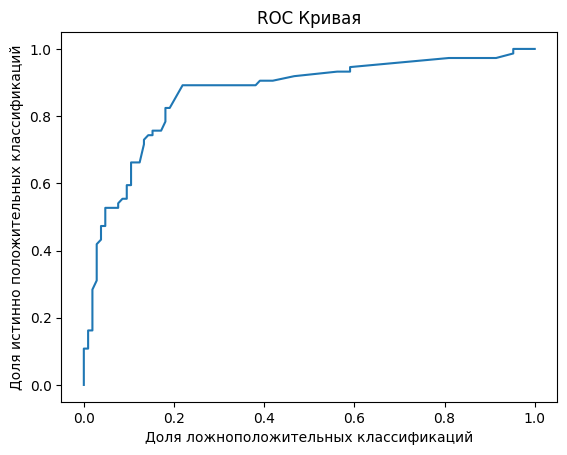

In [11]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(X_test))

plt.plot(fpr, tpr)
plt.title("ROC Кривая")
plt.xlabel("Доля ложноположительных классификаций")
plt.ylabel("Доля истинно положительных классификаций")

print(f"ROC-AUC Score is {roc_auc_score(y_test, y_pred)}")

# 3. Проверка

In [24]:
valid_data = pd.read_csv("test.csv")
valid_target = pd.read_csv("gender_submission.csv")

test = valid_data.merge(
    right=valid_target,
    on="PassengerId",
    how="outer"
)

y_valid = test["Survived"]
X_valid = test.drop(columns=["PassengerId", "Survived"])
X_valid.head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


ROC-AUC Score is 0.9586466165413533


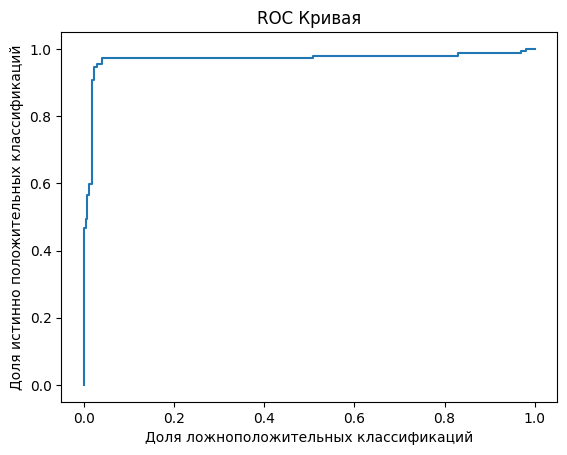

In [28]:
X_valid_ = preprocessing.fit_transform(X_valid[["Pclass", "Sex", "Age", "SibSp", "Parch"]])

y_valid_pred_ = model.predict(X_valid_)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, model.decision_function(X_valid_))

plt.plot(fpr_valid, tpr_valid)
plt.title("ROC Кривая")
plt.xlabel("Доля ложноположительных классификаций")
plt.ylabel("Доля истинно положительных классификаций")

print(f"ROC-AUC Score is {roc_auc_score(y_valid, y_valid_pred_)}")

# Статус
1. Решётчатый поиск с перекрёстной проверкой: найдены оптимальные гиперпараметры.
2. Оценка качества модели: Использовалась метрика ROC-AUC (как наиболее подходящая для бинарной классификации). Результат 75-78% на тестовом наборе и 95% на проверочном наборе демонстрирует хороший результат и хорошую обобщаемость модели.

# 4. Сохранение модели

In [30]:
with open("models/logistic-regression-model.pkl", "wb") as file:
    pickle.dump(model, file)